# Utilizing Risk Factor Scores in Audit Data to Distinguish ‘Risky’ and ‘Not Risky’ Businesses

## 1. Introduction

Auditing is the process of investigating the financial records of businesses to ensure that they comply with internationally-accepted legal standards. In this project, the dataset used is the Audit Data collected by the Comptroller and Auditor General (CAG) in India between 2015-2016. This data focuses on 777 firms from 46 Indian cities that were grouped into 14 different sectors. The CAG investigated risk factors relevant to assisting auditors in accurately identifying businesses that pose a risk of committing unfair practices (N. Hooda et al., 2018). 
Our project revolves around applying predictive analytics in the classification of fraudulent firms using the case study above. Therefore, we will attempt to tackle the research question: Is a business risky or not risky of committing fraud based on its Inherent, Control, and Detection Risk scores?

The product of discrepancies that may occur during the companies’ transactions (Inherent risk), internal audit (Control risk), and external audit (Detection risk) gives us the Audit Risk score (ARS). In the risk assessment, the companies with ARS scores greater than or equal to 1 are identified as ‘risky’ firms and are assigned a risk assessment value of 1, and companies scoring less than 1 are classified as ‘not risky’ firms, getting a risk assessment score of 0.

Potential limitations include manipulation/incorrect logging of companies’ transactions at the internal audit stage to obtain lower Control risk scores, and exclusion of other possible relevant factors that can influence the prediction.

## 2. Preliminary Explanatory Data Analysis

In [21]:
#load library
options(repr.matrix.max.rows=8)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)

In [22]:
#Read dataset and correct variable types
audit_data <- read_csv("data/audit_risk.csv") |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.integer(LOCATION_ID))

#Splitting data into training set and testing set
set.seed(265)
audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

#Printing training data set
audit_training

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0
3.89,8,3.98,0.6,2.388,0.99,0.2,0.198,4.97,5,⋯,0.4,0,0.2,0,2.4,4.372,0.4,0.5,0.8744,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,1.2,0,0.2,0,2.4,2.200,1.2,0.5,1.3200,1
55.57,2,1.06,0.4,0.424,0.63,0.2,0.126,1.69,5,⋯,1.2,0,0.2,0,2.6,2.930,1.2,0.5,1.7580,1
55.57,32,0.00,0.2,0.000,8.49,0.6,5.094,8.49,5,⋯,0.4,0,0.2,0,3.2,6.580,0.4,0.5,1.3160,1
55.57,13,1.06,0.4,0.424,1.60,0.4,0.640,2.66,5,⋯,0.4,0,0.2,0,3.2,12.118,0.4,0.5,2.4236,1


In [23]:
#Table reporting number of sectors and number of firms under each sector
firm_count <- audit_training |>
    select(LOCATION_ID) |>
group_by(LOCATION_ID) |>
    summarise(firm_count = n())
print(firm_count)

# A tibble: 42 × 2
   LOCATION_ID firm_count
         <int>      <int>
 1           1          9
 2           2         33
 3           3          3
 4           4         27
 5           5         35
 6           6         27
 7           7          4
 8           8         58
 9           9         42
10          11         18
# … with 32 more rows


The number of firms under each sector is counted using sector-unique historical risk score value (Sector_Score). The table shows 13 different sectors and the brief count of firms under each of them. Nonetheless, using Sector_Score may not produce the most accurate count as there could be some sectors with equal historical risk scores. 

### Summary Table

In [30]:
#Creating summary table of relevant variables
average_risk_factors <- audit_training |> 
    select(Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk) |> 
    map_dfc(mean, na.rm = TRUE)
average_risk_factors

Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
<dbl>,<dbl>,<dbl>,<dbl>
17.66497,0.5772806,0.5,6.275287


The average of audit risk score is 6.27, which is more than the benchmark 1 (according to the clear depiction in the plots below). This summary table alone could signify that most of the nominated businesses will likely be classified as risky. However, we have to keep in mind that the average value could be skewed by the extreme outliers.

### Relationship between variables

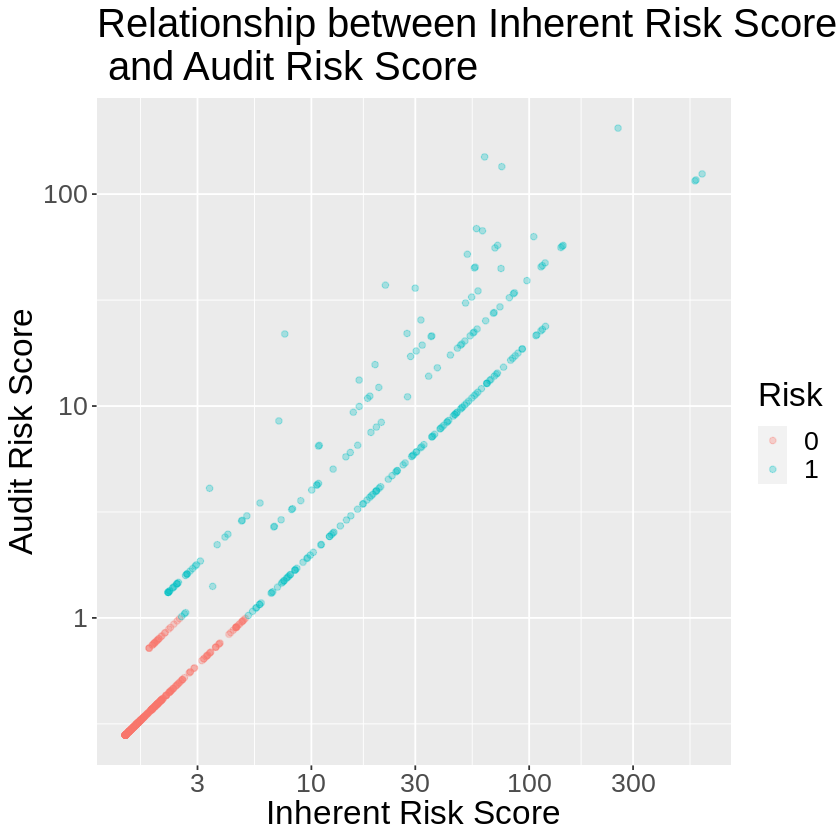

In [32]:
#Setting up plot size
options(repr.plot.width = 7, repr.plot.height = 7)

IR_AR_plot <- audit_training |>
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Inherent Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Inherent Risk Score \n and Audit Risk Score') +
    theme(text = element_text(size =20))
IR_AR_plot

We see a strong positive linear relationship between Audit Risk Score and Inherent Risk Score. It also seems that the companies that are ‘not risky’ are clustered below an Audit Risk score of 1 whereas the ‘risky’ firms are spread out above an Audit Risk score of 1.

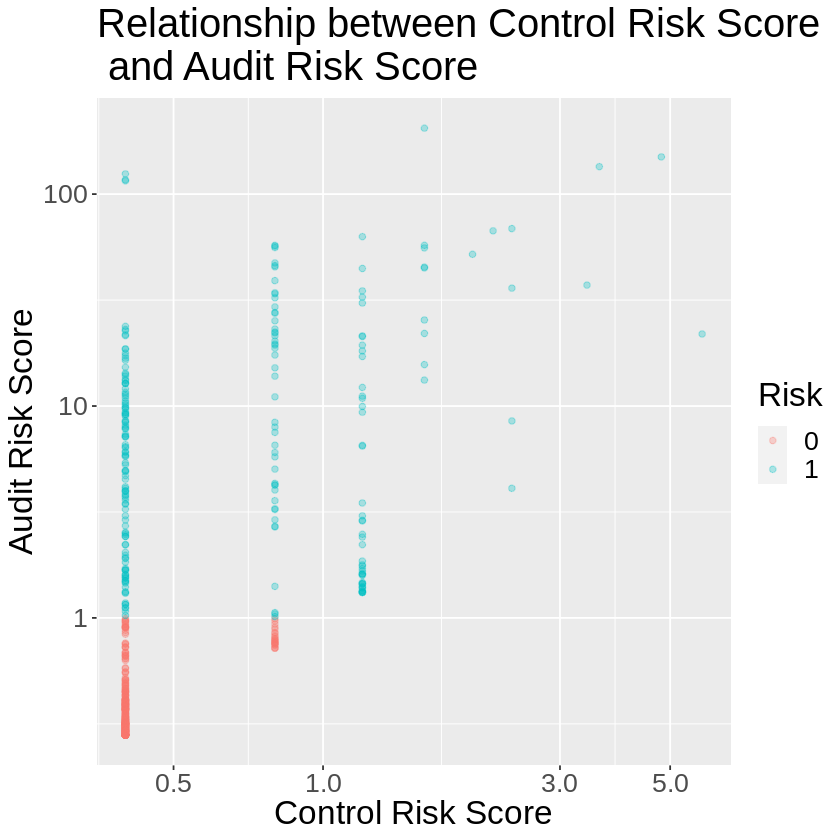

In [33]:
CR_AR_plot <- audit_training |>
    ggplot(aes(x = CONTROL_RISK, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Control Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Control Risk Score \n and Audit Risk Score') +
    theme(text = element_text(size =20))
CR_AR_plot

The ‘not risky’ companies have a constant Control Risk Score of approximately 0.2 or 0.8. In contrast, the ‘risky’ companies show some variation, with Control Risk scores going above 1. However, a good amount of observations are also found at 0.2 and 0.8. Overall, the relationship between Control Risk Score and Audit Risk Score show a linear and slightly positive relationship with a few outliers among ‘risky’ companies.

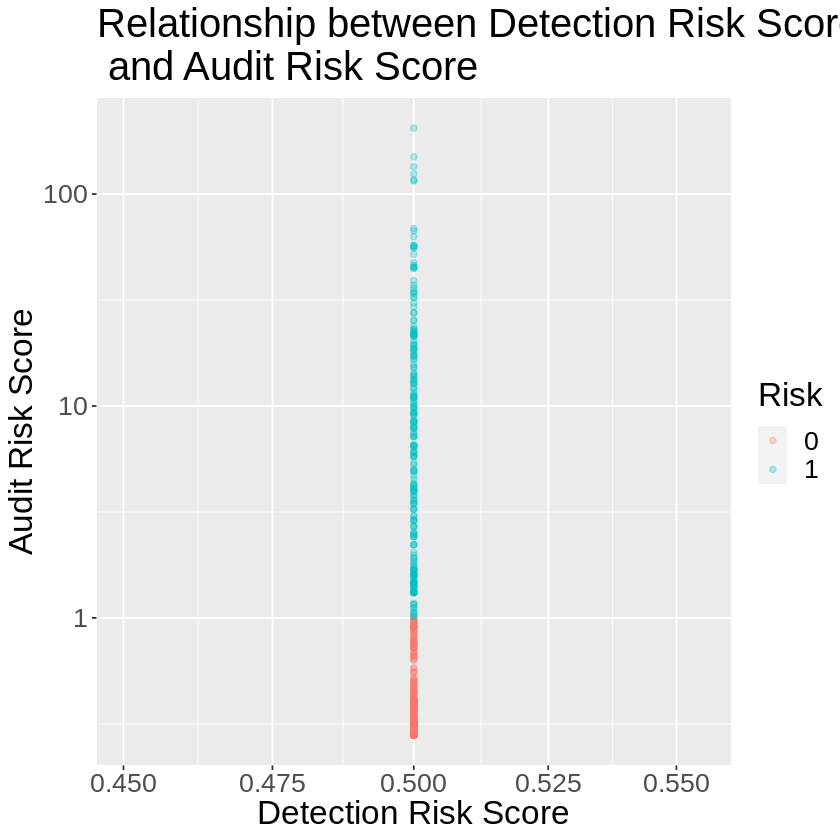

In [34]:
DR_AR_plot <- audit_training |>
    ggplot(aes(x = Detection_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Detection Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Detection Risk Score \n and Audit Risk Score') +
    theme(text = element_text(size =20))
DR_AR_plot

Since the Detection Risk is constant at 0.5 throughout the dataset, it has no relationship with the Audit Risk Score.

Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”


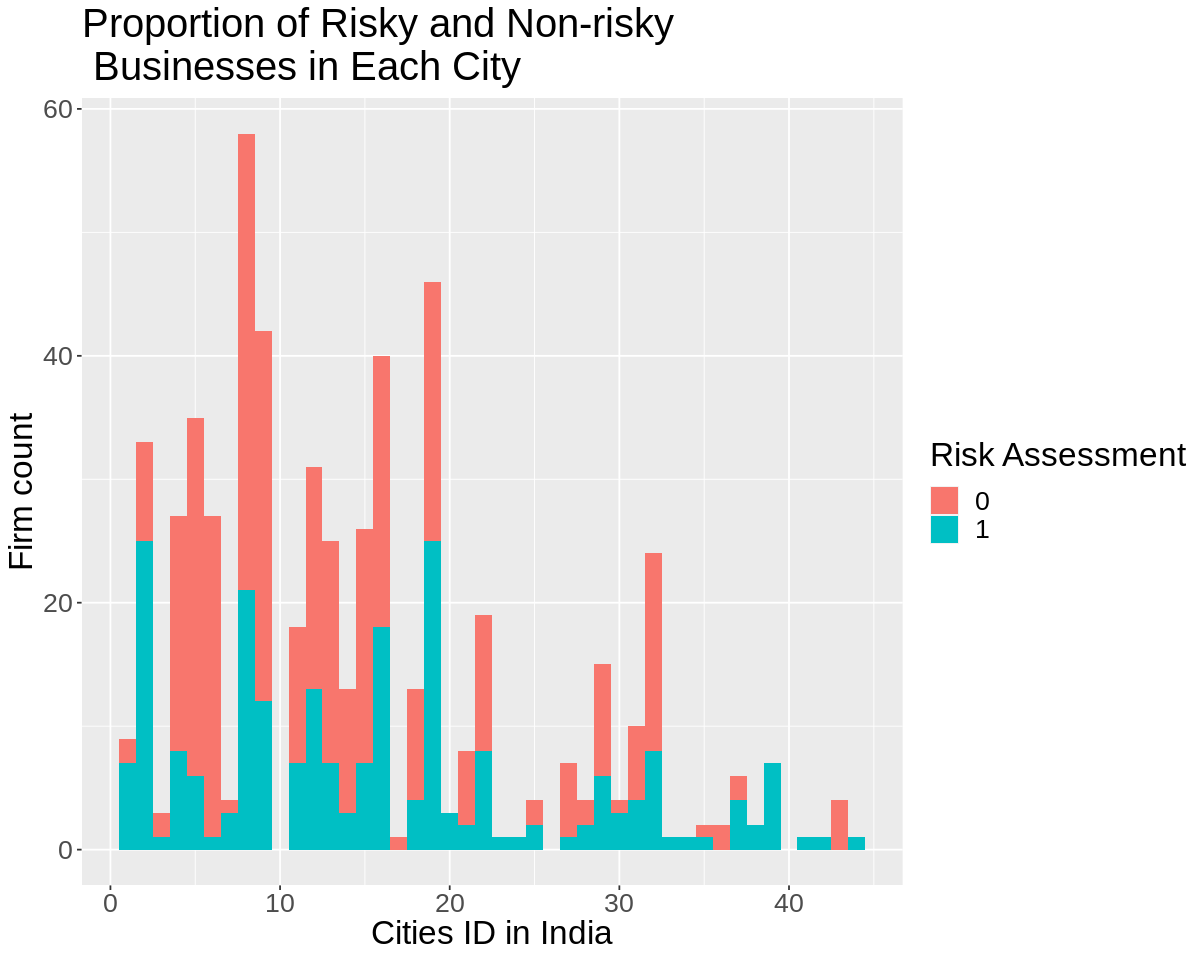

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)

#Visualize Risky and Not Risky proportion in the training data set
Risk_proportion <- audit_training |>
    ggplot(aes(LOCATION_ID, fill = Risk))+
    geom_histogram(binwidth = 1) +
    labs(x = 'Cities ID in India', y = 'Firm count', fill = 'Risk Assessment') +
    theme(text = element_text(size = 20)) +
    ggtitle('Proportion of Risky and Non-risky \n Businesses in Each City')
Risk_proportion

In [39]:
#Calculate raw value of class counts
Risk_count <- audit_training |>
    select(Risk) |>
    summary(count = n(Risk))
Risk_count

#Calculate proportion percentage for each class
proportion <- tibble(Not_Risky = 353/(353+228)*100, Risky = 228/(353+228)*100)
proportion

 Risk   
 0:353  
 1:228  

Not_Risky,Risky
<dbl>,<dbl>
60.75731,39.24269


The proportion between Risky and Not Risky businesses in the training data set is not significantly different, hence our prediction will not lean more towards one class than the other.

## 3. Methods

We will conduct our data analysis using the K-Nearest Neighbours (K-NN) classification model to predict the Risk classification of a business. 

The predictor variables we will use are Inherent_Risk and Control_Risk. Although the Audit Risk score (ARS) includes the aforementioned risk factors as well as the Detection_Risk, the Detection Risk score has a constant value of 0.5 throughout the dataset. Hence, it will not be included in our model as it does not influence the ARS.

Since the relevant variables are numerical values, the results will be visualized using scatter plots to determine the respective relationships of each risk factor with the audit risk. By doing so, we can see how each risk factor directly impacts the audit score and we can compare the strengths of each relationship to identify which risk factor influences the ARS the greatest; thereby determining the Risk classification. 

A confusion matrix depicting predicted results and the correct class will also be created to evaluate our model’s accuracy. 

## 4. Expected Outcomes and Significance

According to the strong linear relationships depicted in the scatter plots above, we expect that including these variables will allow our model to be fairly accurate in predicting which business is risky or not. With an accurate model, we can identify the businesses that pose the most risk of committing fraud better.  

While these findings can help improve auditing practices for future investigations, it also raises the question of how we can ensure that the targetted businesses’ financial statements were not manipulated. Additionally, is there any way we can reduce the number of companies that commit fraud? Furthermore, what are the leading causes of companies having high Audit Risk in the first place?